# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling MATIC](#Modeling)
 * [MATIC - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [MATIC - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [MATIC - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - MATIC<a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of MATIC.

# MATIC - Entire Dataset <a name="entiredataset"></a>

In [3]:
matic = pd.read_csv('MATIC.csv', index_col = 'Date')

In [4]:
matic.head()

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2019-05-13,0.000319,0.007652,0.868354,0.914201,0.999480,0.343941,0.045436
2019-05-14,0.000000,0.010239,0.801153,0.532984,0.996507,0.341617,0.048304
2019-05-15,0.000613,0.004913,0.786702,0.438745,0.999475,0.324949,0.051671
2019-05-16,0.001100,0.006003,0.773782,0.440960,0.998908,0.326589,0.046554
2019-05-17,0.002300,0.017904,0.900332,0.623460,0.999255,0.306584,0.037911


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = matic.copy()

In [6]:
data.head()

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2019-05-13,0.000319,0.007652,0.868354,0.914201,0.999480,0.343941,0.045436
2019-05-14,0.000000,0.010239,0.801153,0.532984,0.996507,0.341617,0.048304
2019-05-15,0.000613,0.004913,0.786702,0.438745,0.999475,0.324949,0.051671
2019-05-16,0.001100,0.006003,0.773782,0.440960,0.998908,0.326589,0.046554
2019-05-17,0.002300,0.017904,0.900332,0.623460,0.999255,0.306584,0.037911


In [7]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days a the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'BTC_closeprice','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [8]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
1072
1072


In [9]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [10]:
target = target.reshape(-1,1)
target.shape

(1072, 1)

In [11]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [12]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(863, 7, 6)

In [13]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2160      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,665
Trainable params: 20,665
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
22/22 [==============================] - 5s 50ms/step - loss: 7.5525e-04 - val_loss: 0.1749
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 8.6262e-04 - val_loss: 0.1777
Epoch 3/30
22/22 [==============================] - 0s 14ms/step - loss: 6.1564e-04 - val_loss: 0.1686
Epoch 4/30
22/22 [==============================] - 0s 11ms/step - loss: 4.4355e-04 - val_loss: 0.1589
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 3.1027e-04 - val_loss: 0.1462
Epoch 6/30
22/22 [==============================] - 0s 11ms/step - loss: 2.8215e-04 - val_loss: 0.1407
Epoch 7/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9451e-04 - val_loss: 0.1420
Epoch 8/30
22/22 [==============================] - 0s 10ms/step - loss: 2.3980e-04 - val_loss: 0.1381
Epoch 9/30
22/22 [==============================] - 0s 10ms/step - loss: 3.7311e-04 - val_loss: 0.1568
Epoch 10/30
22/22 [==============================] - 0s 10ms/step - loss:

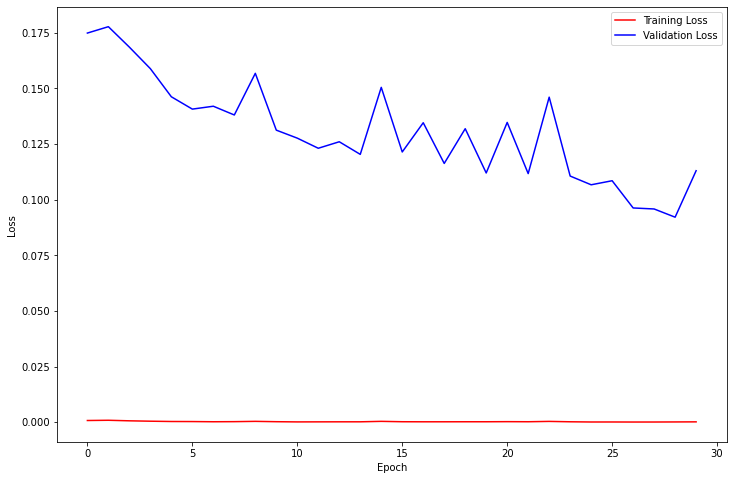

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [17]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [18]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
204,0.478253,0.100589,2022-04-21
205,0.484972,0.101364,2022-04-22
206,0.473411,0.102387,2022-04-23
207,0.465838,0.103522,2022-04-24
208,0.468774,0.104236,2022-04-25


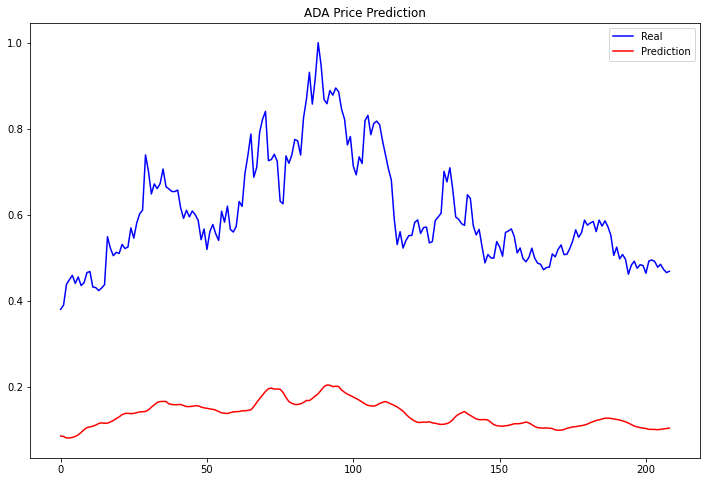

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [20]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.15098674208913787
Train data MSE:  0.022796996286691837
Train data MAE:  0.06661786120104773
-------------------------------------------------------------------------------------
Test data RMSE:  0.4797911649275998
Test data MSE:  0.2301995619425833
Test data MAE:  0.4686485212708497


In [21]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.23241005406152504
Test data R2 score: -13.424323903699808


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [22]:
data1 = matic.copy()
data1.reset_index(inplace = True)
data1.shape

(1079, 8)

In [23]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  1079


In [24]:
data1.set_index('Date', inplace = True)
data1.shape

(1079, 7)

In [25]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (863, 7)
test_data:  (216, 7)


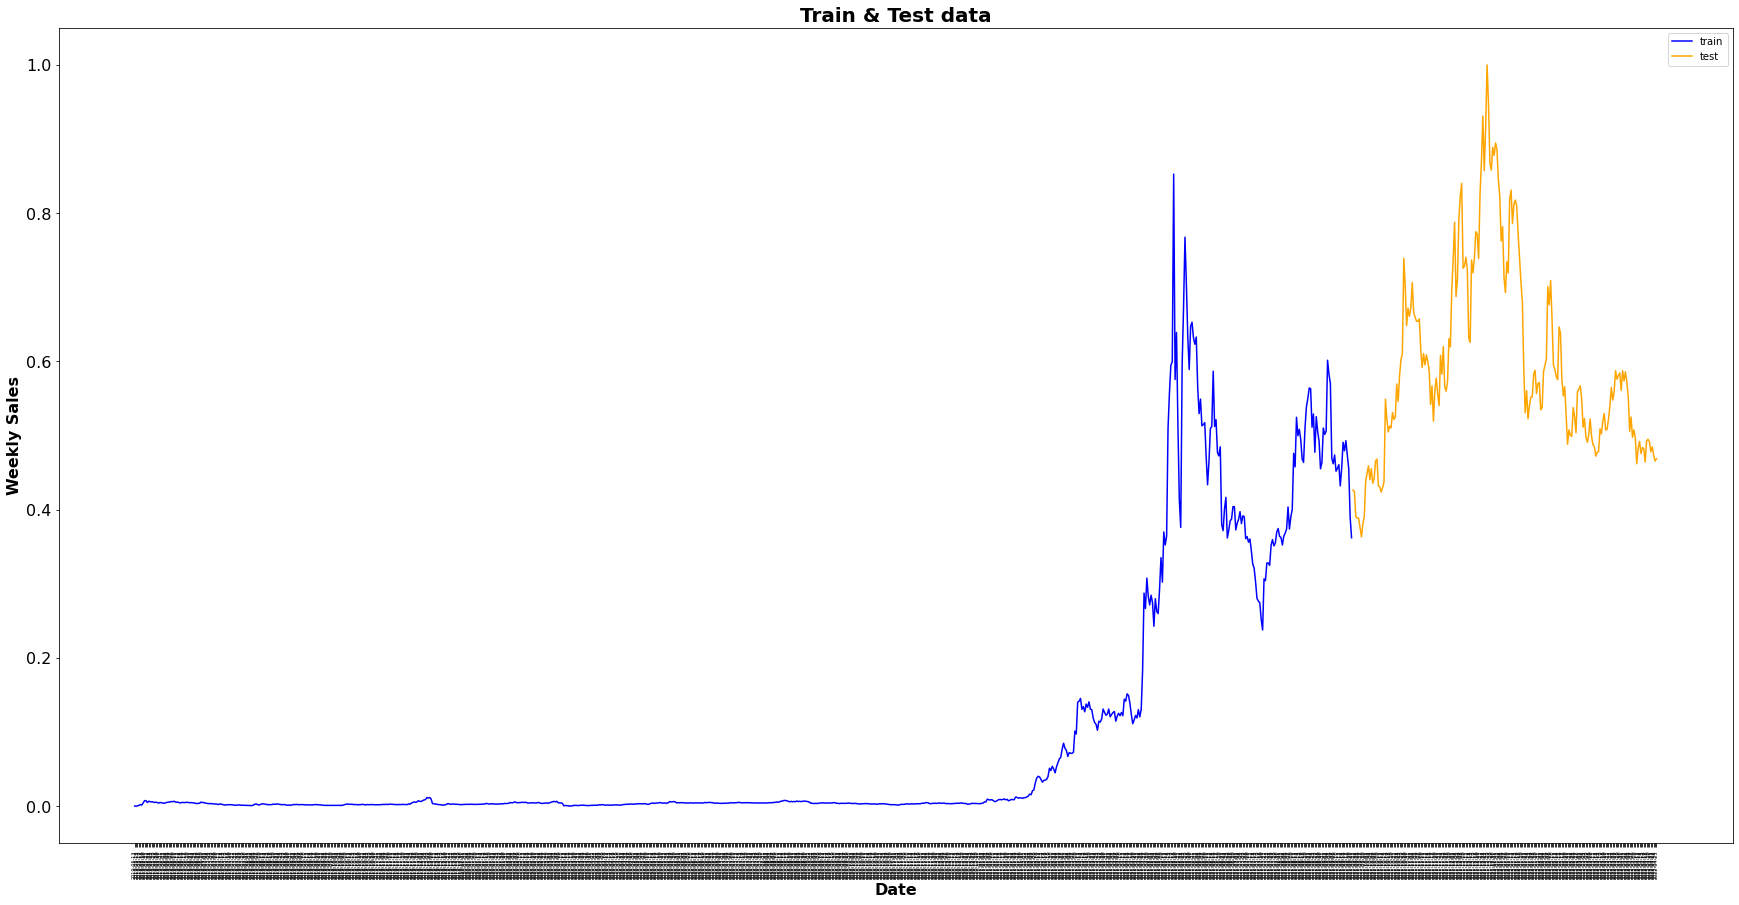

In [26]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [27]:
data1.set_index('Date', inplace = True)

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 1:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (855, 7, 6)
y_train:  (855,)
X_test:  (208, 7, 6)
y_test (208,)


In [30]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [31]:
model1 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [32]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train)

In [33]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
203,0.491457,0.305300,2022-04-21
204,0.478253,0.348893,2022-04-22
205,0.484972,0.322445,2022-04-23
206,0.473411,0.385004,2022-04-24
207,0.465838,0.408563,2022-04-25


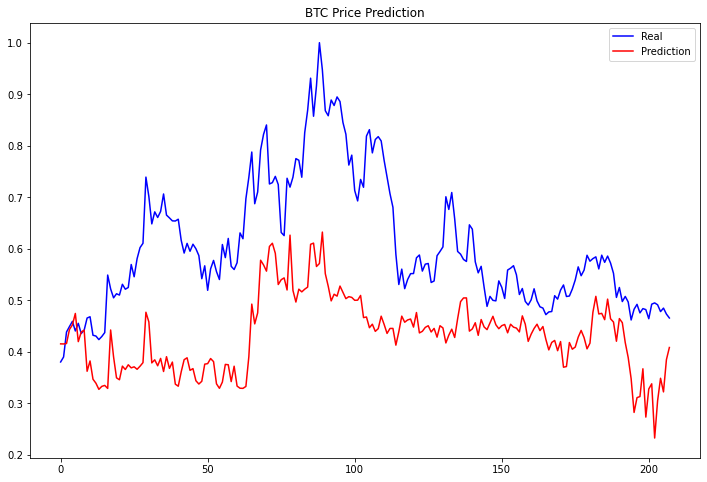

In [34]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

In [35]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  2.699506509518863e-07
Mean Absolute Error - MAE : 0.00036849491808096946
Root Mean squared Error - RMSE : 0.000519567753956966
R^2 Score 0.9999907316463722
--------------------------------------------------------------
Test data MSE:  0.04013285909030266
Mean Absolute Error - MAE : 0.1741356269836943
Root Mean squared Error - RMSE : 0.20033187237756916
R^2 Score -1.5167289716446062


# MATIC - since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [36]:
data2 = matic.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [37]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume','BTC_closeprice','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [38]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [39]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [40]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [41]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [42]:
X_train.shape

(384, 7, 6)

In [43]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 85ms/step - loss: 0.1133 - val_loss: 0.3781
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 0.0537 - val_loss: 0.2138
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0308 - val_loss: 0.1104
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0471 - val_loss: 0.1200
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0427 - val_loss: 0.1317
Epoch 6/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0354 - val_loss: 0.1080
Epoch 7/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0306 - val_loss: 0.0755
Epoch 8/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0286 - val_loss: 0.0538
Epoch 9/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0270 - val_loss: 0.0353
Epoch 10/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0226 - val_loss: 0.0254
Epoch 11/

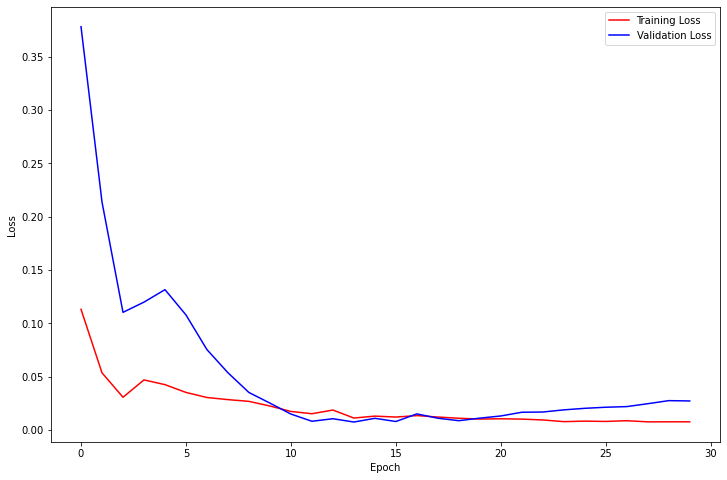

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [47]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [48]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.552084,0.528236,2022-01-27
1,0.582594,0.520217,2022-01-28
2,0.588083,0.514634,2022-01-29
3,0.556840,0.513996,2022-01-30
4,0.570291,0.513559,2022-01-31


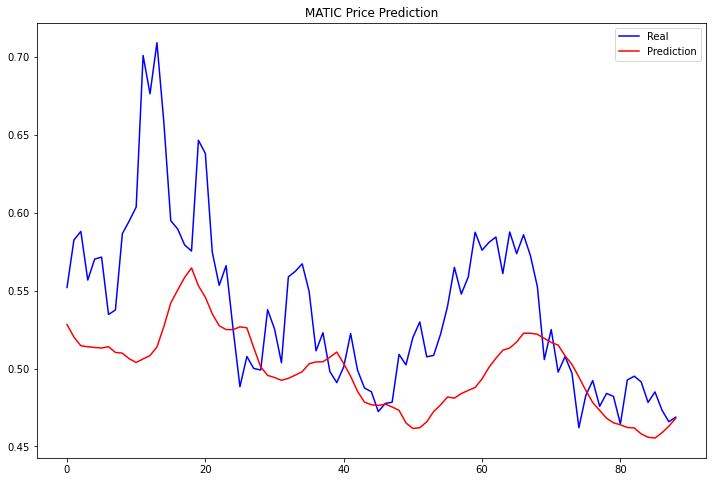

In [49]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('MATIC Price Prediction')
plt.legend()
plt.show()

In [50]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.09127586075506833
Train data MSE:  0.008331282756578622
Train data MAE:  0.059494820490843425
-------------------------------------------------------------------------------------
Test data RMSE:  0.05845753143041022
Test data MSE:  0.003417282980937399
Test data MAE:  0.0430260597086085


In [51]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.8677517908366165
Test data R2 score: -0.19502611534850334


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [52]:
data3 = matic.copy()

In [53]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [54]:
data3.shape

(480, 7)

In [55]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 7)
test_data:  (96, 7)


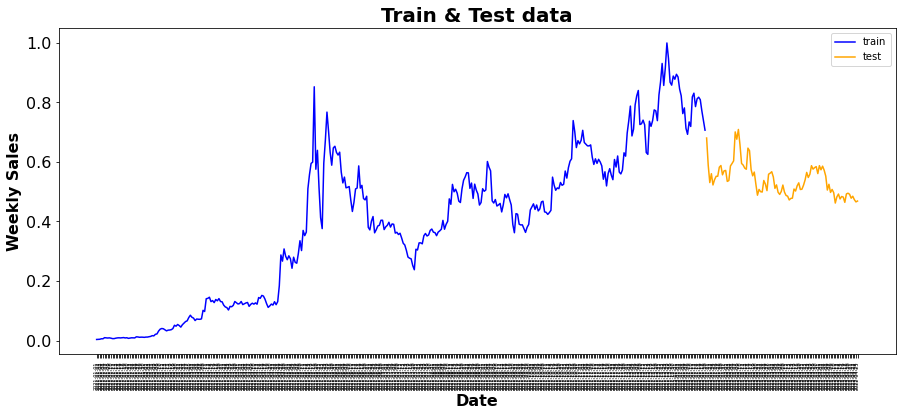

In [56]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [57]:
data3.set_index('Date', inplace = True)

In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 7)
y_train:  (376,)
X_test:  (88, 7, 7)
y_test (88,)


In [60]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [61]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [62]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [63]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.491457,0.493809,2022-04-21
84,0.478253,0.499741,2022-04-22
85,0.484972,0.488281,2022-04-23
86,0.473411,0.477429,2022-04-24
87,0.465838,0.465044,2022-04-25


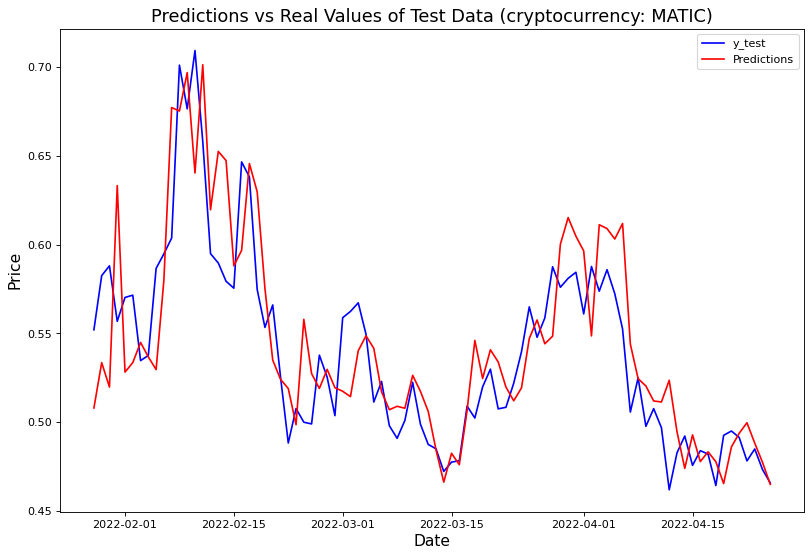

In [64]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: MATIC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [65]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  3.9853202740570274e-07
Mean Absolute Error - MAE : 0.0004681256409610305
Root Mean squared Error - RMSE : 0.0006312939310699119
R^2 Score 0.9999937258919092
--------------------------------------------------------------
Test data MSE:  0.0010115718180287601
Mean Absolute Error - MAE : 0.024629679550430657
Root Mean squared Error - RMSE : 0.031805216836688285
R^2 Score 0.6433614582900482


# MATIC - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [66]:
data4 = matic.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [67]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'BTC_closeprice', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [68]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [69]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [70]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [71]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [72]:
X_train.shape

(92, 7, 6)

In [73]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [74]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [75]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 273ms/step - loss: 0.3251 - val_loss: 0.2444
Epoch 2/30
3/3 [==============================] - 0s 22ms/step - loss: 0.2726 - val_loss: 0.1964
Epoch 3/30
3/3 [==============================] - 0s 23ms/step - loss: 0.2209 - val_loss: 0.1452
Epoch 4/30
3/3 [==============================] - 0s 22ms/step - loss: 0.1633 - val_loss: 0.0896
Epoch 5/30
3/3 [==============================] - 0s 22ms/step - loss: 0.1010 - val_loss: 0.0355
Epoch 6/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0444 - val_loss: 0.0021
Epoch 7/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0210 - val_loss: 0.0136
Epoch 8/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0270 - val_loss: 0.0194
Epoch 9/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0231 - val_loss: 0.0071
Epoch 10/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0141 - val_loss: 8.7422e-04
Epoch 11/30
3/3 [=======

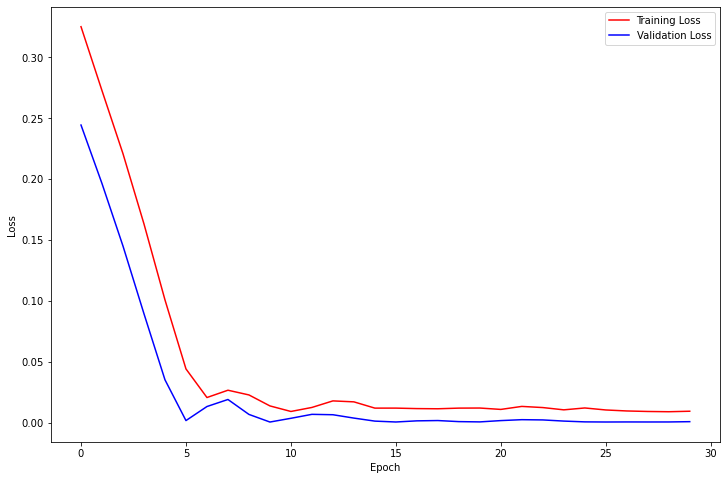

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [77]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [78]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.478253,0.504434,2022-04-21
12,0.484972,0.505171,2022-04-22
13,0.473411,0.504089,2022-04-23
14,0.465838,0.503368,2022-04-24
15,0.468774,0.504767,2022-04-25


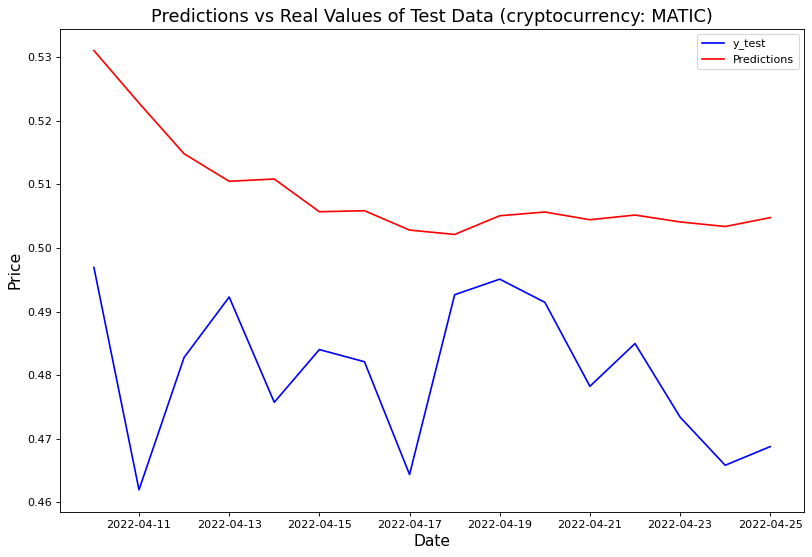

In [79]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: MATIC)', fontsize = 16,)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [80]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.0772956232587302
Train data MSE:  0.005974613374955554
Train data MAE:  0.05181778074614278
-------------------------------------------------------------------------------------
Test data RMSE:  0.03070620083274641
Test data MSE:  0.0009428707695809562
Test data MAE:  0.02801632762904038


In [81]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.24436436702815378
Test data R2 score: -6.687433442887299


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [82]:
data5= matic.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [83]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 7)
test_data:  (23, 7)


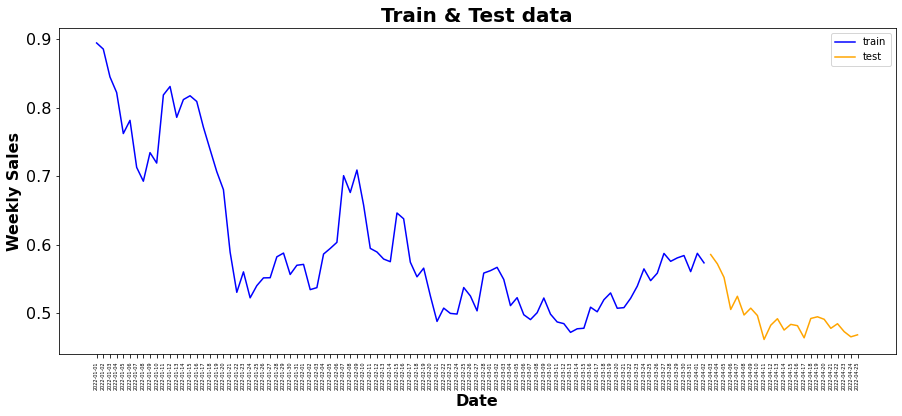

In [84]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [85]:
data5.set_index('Date', inplace = True)

In [86]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [87]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 7)
y_train:  (84,)
X_test:  (15, 7, 7)
y_test (15,)


In [88]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [89]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [90]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [91]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.491457,0.505857,2022-04-21
11,0.478253,0.494270,2022-04-22
12,0.484972,0.510257,2022-04-23
13,0.473411,0.512339,2022-04-24
14,0.465838,0.503304,2022-04-25


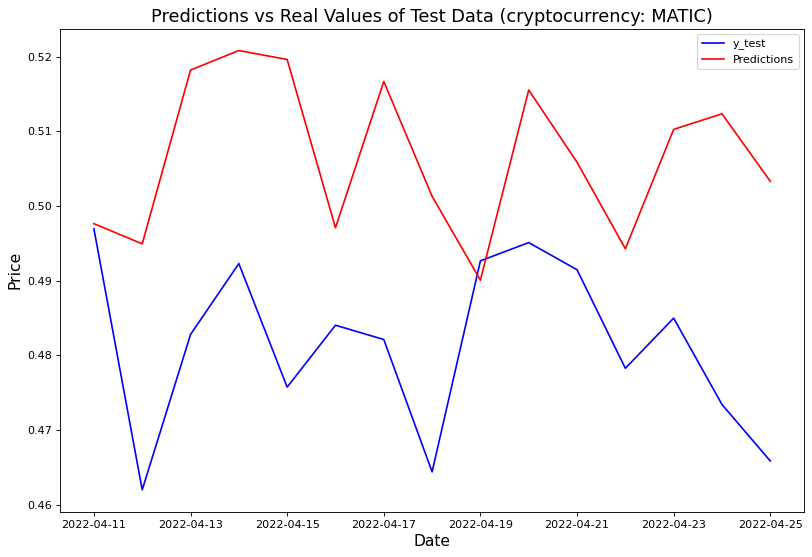

In [92]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: MATIC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [93]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.371112366434746e-07
Mean Absolute Error - MAE : 0.0002616606722909103
Root Mean squared Error - RMSE : 0.00037028534489427827
R^2 Score 0.9999836437716435
--------------------------------------------------------------
Test data MSE:  0.000816973207009344
Mean Absolute Error - MAE : 0.02540797109293647
Root Mean squared Error - RMSE : 0.028582743168026125
R^2 Score -5.764828380329906


# Predictions for the next two days using the best model <a name="predictions"></a>

In [94]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_MATIC.csv', index_col = 'Date')

In [95]:
predictions.tail(7)

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2022-05-02,0.372895,0.077998,0.076977,0.061691,0.957596,0.017292,0.536113
2022-05-03,0.372326,0.058609,0.110625,0.038474,0.961451,0.002644,0.523670
2022-05-04,0.405464,0.080514,0.162876,0.088311,0.999886,0.013245,0.554789
2022-05-05,0.368399,0.082281,0.153229,0.133863,0.876055,0.064389,0.504894
2022-05-06,0.361233,0.076340,0.134917,0.038684,0.967953,0.019347,0.496359
2022-05-07,0.353241,0.066992,0.045235,0.052400,0.955935,0.019347,0.487749
2022-05-08,0.338804,0.062373,0.027520,0.049226,0.952406,0.019347,0.467378


In [96]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [97]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [98]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.37289525 0.07799766 0.07697735 0.06169101 0.95759609 0.01729174
 0.53611283 0.37232642 0.05860915 0.11062539 0.0384745  0.96145052
 0.00264389 0.52366995 0.4054644  0.08051369 0.16287638 0.08831107
 0.99988562 0.01324543 0.55478882 0.36839892 0.08228067 0.15322907
 0.13386309 0.87605498 0.06438862 0.5048938  0.36123337 0.07634016
 0.13491677 0.03868428 0.96795288 0.01934702 0.49635941 0.35324141
 0.06699187 0.04523543 0.0523997  0.95593451 0.01934702 0.48774915
 0.3388045  0.0623727  0.02752043 0.04922617 0.95240573 0.01934702
 0.46737795]
0 day output [0.36656293]
Output of predicted next days:  1


In [99]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.36656293272972107]

In [100]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [101]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [102]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
0,2022-05-08,0.338804,0.062373,0.02752,0.049226,0.952406,0.019347,0.467378


In [103]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2022-05-09,0.366563,0.062373,0.02752,0.049226,0.952406,0.019347,0.467378


In [104]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [105]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((2.876757-0.003141)*output9[0])+0.003141

print ("The predicted closing price for MATIC on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for MATIC on May 9th, 2022 is  1.0565021084990502 USD


# Final Predictions<a name="finalpredictions"></a>

In [106]:
final_predictions.tail(7)

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2022-05-03,0.372326,0.058609,0.110625,0.038474,0.961451,0.002644,0.523670
2022-05-04,0.405464,0.080514,0.162876,0.088311,0.999886,0.013245,0.554789
2022-05-05,0.368399,0.082281,0.153229,0.133863,0.876055,0.064389,0.504894
2022-05-06,0.361233,0.076340,0.134917,0.038684,0.967953,0.019347,0.496359
2022-05-07,0.353241,0.066992,0.045235,0.052400,0.955935,0.019347,0.487749
2022-05-08,0.338804,0.062373,0.027520,0.049226,0.952406,0.019347,0.467378
2022-05-09,0.366563,0.062373,0.027520,0.049226,0.952406,0.019347,0.467378


In [107]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [108]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [109]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.37232642 0.05860915 0.11062539 0.0384745  0.96145052 0.00264389
 0.52366995 0.4054644  0.08051369 0.16287638 0.08831107 0.99988562
 0.01324543 0.55478882 0.36839892 0.08228067 0.15322907 0.13386309
 0.87605498 0.06438862 0.5048938  0.36123337 0.07634016 0.13491677
 0.03868428 0.96795288 0.01934702 0.49635941 0.35324141 0.06699187
 0.04523543 0.0523997  0.95593451 0.01934702 0.48774915 0.3388045
 0.0623727  0.02752043 0.04922617 0.95240573 0.01934702 0.46737795
 0.36656293 0.0623727  0.02752043 0.04922617 0.95240573 0.01934702
 0.46737795]
0 day output [0.41961133]
Output of predicted next days:  1


In [110]:
print ("The predicted normalized closing price for MATIC on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for MATIC on May 10th, 2022 is  0.4196113348007202


In [111]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((2.876757-0.003141)*output10[0])+0.003141

print ("The predicted closing price for MATIC on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for MATIC on May 10th, 2022 is  1.2089428454647067 USD
